In [31]:
# !pip install wfdb==4.1.2

import os, sys, warnings, random, gc
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Optional, Tuple

import gc, numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import callbacks
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             precision_recall_curve, confusion_matrix,
                             precision_score, recall_score, f1_score)


from scipy.signal import butter, filtfilt, resample_poly, stft, get_window
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers


import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,           # احتمالاً از قبل داری
    average_precision_score, # AUPRC
    roc_curve,               # برای منحنی ROC
    precision_recall_curve   # برای منحنی PR
)

warnings.filterwarnings('ignore')
print('Python:', sys.version)
print('TF:', tf.__version__)

SEED = 99
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"


Python: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
TF: 2.20.0


In [32]:
# ---- Simple imbalance handler (no-SMOTE) ----
import numpy as np
import tensorflow as tf

SEED = 99  # یا همون سید دلخواه
np.random.seed(SEED); tf.random.set_seed(SEED)

# تنظیمات
AUG_POS_MULT = 2   # چند برابر کردن نمونه‌های مثبت
BATCH_SIZE   = 32  # سایز بچ

def build_train_dataset_no_smote(S_tr, G_tr, y_tr,
                                 batch_size=BATCH_SIZE,
                                 pos_mult=AUG_POS_MULT,
                                 use_mixup=True, mixup_alpha=0.2):
    """
    فقط Oversample روی کلاس مثبت و (اختیاری) MixUp روی batch.
    هیچ وابستگی خارجی ندارد.
    """
    S_tr = np.asarray(S_tr); G_tr = np.asarray(G_tr); y_tr = np.asarray(y_tr).astype(np.int32).ravel()

    # 1) Oversample دستیِ کلاس مثبت
    pos_idx = np.where(y_tr == 1)[0]
    if len(pos_idx) and pos_mult > 1:
        rep = np.random.choice(pos_idx, size=len(pos_idx)*(pos_mult-1), replace=True)
        S_up = np.concatenate([S_tr, S_tr[rep]], axis=0)
        G_up = np.concatenate([G_tr, G_tr[rep]], axis=0)
        y_up = np.concatenate([y_tr, y_tr[rep]], axis=0)
    else:
        S_up, G_up, y_up = S_tr, G_tr, y_tr

    ds = tf.data.Dataset.from_tensor_slices(
        (S_up.astype(np.float32), G_up.astype(np.float32), y_up.astype(np.int32))
    )
    ds = ds.shuffle(4096, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    if not use_mixup:
        return ds

    # 2) MixUp ساده روی batch
    def mixup_batch(S, G, y):
        bs = tf.shape(y)[0]
        idx = tf.random.shuffle(tf.range(bs))
        S2, G2, y2 = tf.gather(S, idx), tf.gather(G, idx), tf.gather(y, idx)

        lam = tf.random.gamma(shape=[bs], alpha=mixup_alpha, beta=1.0)
        lam = lam / (lam + tf.random.gamma(shape=[bs], alpha=mixup_alpha, beta=1.0))
        lam = tf.reshape(lam, [-1, 1, 1])  # برای S

        S_mix = lam * S + (1.0 - lam) * S2
        lam_g = tf.reshape(lam[:,0,0], [-1, 1])  # برای G
        G_mix = lam_g * G + (1.0 - lam_g) * G2

        y  = tf.cast(y,  tf.float32)
        y2 = tf.cast(y2, tf.float32)
        y_mix = tf.reshape(lam[:,0,0], [-1, 1]) * y + (1.0 - tf.reshape(lam[:,0,0], [-1, 1])) * y2
        return S_mix, G_mix, y_mix

    ds = ds.map(mixup_batch, num_parallel_calls=tf.data.AUTOTUNE)
    return ds


In [33]:
DATA_DIR = Path(r"C:\Users\admin\Desktop\new-cod\tpehg")

CSV_PATH = r"C:/Users/admin/Desktop/new-cod/ehg_clean_dataset_with_clinical_labels.csv"

df = pd.read_csv(CSV_PATH)
df['label'] = df['record_type'].map({'Term': 0, 'Preterm': 1})
df = df.dropna(subset=['label']).reset_index(drop=True)
df['label'] = df['label'].astype(int)
df['record'] = df['filename'].apply(lambda fn: Path(fn).stem)

print('Rows:', len(df), '| Pos rate:', df['label'].mean().round(4))


Rows: 326 | Pos rate: 0.1564


In [34]:
import wfdb

FS_ORIG = 20.0
FS_TARGET = 10.0
REMOVE_FIRST_SEC = 60
TARGET_MINUTES = 30
TARGET_SAMPLES = int(TARGET_MINUTES * 60 * FS_TARGET)

SEARCH_SUBDIRS = ["", "tpehgdb", "tpehgt"]

def resolve_record_path(record: str) -> Optional[Path]:
    for sub in SEARCH_SUBDIRS:
        base = (DATA_DIR / sub).resolve()
        hea = base / f"{record}.hea"
        dat = base / f"{record}.dat"
        if hea.exists() and dat.exists():
            return base / record
    return None

def butter_bandpass(low, high, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return b, a

BPF = butter_bandpass(0.05, 4.0, FS_ORIG)

def pick_channel_index(sig_names: List[str]) -> int:
    low = [s.lower() for s in sig_names]
    for key in ["ehg1", "s1", "ehg 1", "ehg-1", "uterus1"]:
        if key in low:
            return low.index(key)
    return 0

def load_s1_signal(record: str) -> np.ndarray:
    base = resolve_record_path(record)
    if base is None:
        raise FileNotFoundError(f"Missing {record}.hea/.dat under {DATA_DIR}")
    sig, fields = wfdb.rdsamp(str(base))
    idx = pick_channel_index(fields['sig_name'])
    x = sig[:, idx].astype(np.float64)
    # remove first 60s
    start_rm = int(REMOVE_FIRST_SEC * FS_ORIG)
    x = x[start_rm:] if len(x) > start_rm else np.pad(x, (0, start_rm-len(x)+1))
    # filter & resample
    b, a = BPF
    x = filtfilt(b, a, x)
    x = resample_poly(x, up=1, down=int(FS_ORIG/FS_TARGET))
    # fix length
    if len(x) < TARGET_SAMPLES:
        x = np.pad(x, (0, TARGET_SAMPLES - len(x)))
    elif len(x) > TARGET_SAMPLES:
        x = x[:TARGET_SAMPLES]
    return x


In [35]:
# STFT پارامترها
N_PERSEG  = int(60 * FS_TARGET)   # 600
N_OVERLAP = int(0.75 * N_PERSEG)  # 450
WIN       = get_window('hamming', N_PERSEG, fftbins=True)

# باندهای فرکانسی پیشنهادی برای EHG
BANDS = [(0.05, 0.3), (0.3, 1.0), (1.0, 2.0), (2.0, 4.0)]

def band_indices(fs, nperseg, bands):
    f = np.fft.rfftfreq(nperseg, d=1/fs)
    idxs = []
    for lo, hi in bands:
        idxs.append(np.where((f >= lo) & (f < hi))[0])
    return f, idxs

FREQS, BAND_IDXS = band_indices(FS_TARGET, N_PERSEG, BANDS)

def make_stft_and_bands(x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # STFT
    f, t, Z = stft(
        x, fs=FS_TARGET, window=WIN,
        nperseg=N_PERSEG, noverlap=N_OVERLAP,
        padded=False, boundary=None
    )
    # اسپکتروگرام log-power
    P = np.log1p(np.square(np.abs(Z))).astype(np.float32)  # [freq, time]
    S = np.transpose(P, (1, 0))  # [time, freq]

    # توان میانگین هر باند در هر فریم
    band_powers = []
    for idx in BAND_IDXS:
        if len(idx) == 0:
            band_powers.append(np.zeros(S.shape[0], dtype=np.float32))
        else:
            band_powers.append(P[idx, :].mean(axis=0).astype(np.float32))
    band_powers = np.stack(band_powers, axis=1)  # [time, n_bands]

    # آمار سراسریِ زمانی (میانگین/انحراف معیار) ← فیچر فشرده
    stats = np.concatenate([band_powers.mean(axis=0), band_powers.std(axis=0)], axis=0)  # shape=(n_bands*2,)
    return S, stats


In [36]:
# فقط رکوردهایی که واقعاً فایل‌شان هست را نگه می‌داریم
available, missing = [], []
for rec in df['record'].astype(str):
    base = resolve_record_path(rec)
    ok = base is not None
    available.append(ok)
    if not ok:
        missing.append(rec)

df_av = df[pd.Series(available)].reset_index(drop=True)
print("Available:", len(df_av), "| Missing:", len(missing))
if missing:
    print("Missing examples:", missing[:10])

assert len(df_av) > 0, "هیچ رکوردی روی دیسک پیدا نشد. مسیر DATA_DIR را درست کنید."

# کش محلی
CACHE_DIR = Path("./ehg_cache_v6"); CACHE_DIR.mkdir(exist_ok=True)

def get_features(record: str) -> Tuple[np.ndarray, np.ndarray]:
    fp_S = CACHE_DIR / f"{record}_S.npy"
    fp_g = CACHE_DIR / f"{record}_g.npy"
    if fp_S.exists() and fp_g.exists():
        return np.load(fp_S), np.load(fp_g)
    x = load_s1_signal(record)
    S, g = make_stft_and_bands(x)
    np.save(fp_S, S); np.save(fp_g, g)
    return S, g

# نمونه‌گیری برای فهمیدن ابعاد
N_TIME = N_FREQ = G_DIM = None
for rec in df_av['record'].astype(str):
    try:
        S, g = get_features(rec)
        N_TIME, N_FREQ = S.shape
        G_DIM = int(g.shape[0])
        print("Example shapes:", (N_TIME, N_FREQ), "global_dim:", G_DIM, "from", rec)
        break
    except Exception as e:
        print("Skip", rec, "->", e)

if N_TIME is None:
    N_TIME, N_FREQ, G_DIM = 200, 301, 8
    print("WARNING: Using default fallback shapes:", N_TIME, N_FREQ, G_DIM)


Available: 326 | Missing: 0
Example shapes: (117, 301) global_dim: 8 from tpehg1151


In [37]:
# ستون‌های عددی بالینی را (به‌صورت خودکار) انتخاب می‌کنیم
EXCLUDE = {'filename', 'record', 'record_type', 'label'}
num_cols = [c for c in df_av.columns if c not in EXCLUDE and pd.api.types.is_numeric_dtype(df_av[c])]

print("Clinical numeric columns detected:", num_cols)
clin_matrix = df_av[num_cols].copy() if len(num_cols) > 0 else pd.DataFrame(index=df_av.index)

# جایگزینی مقادیر گمشده با میانگین هر ستون (ساده و امن)
if len(num_cols) > 0:
    for c in num_cols:
        m = clin_matrix[c].mean()
        clin_matrix[c] = clin_matrix[c].fillna(m).astype(np.float32)

clin_matrix = clin_matrix.to_numpy(dtype=np.float32) if len(num_cols) > 0 else np.zeros((len(df_av), 0), np.float32)


Clinical numeric columns detected: ['gestational_age_weeks', 'age', 'weight', 'parity', 'abortions', 'rectime']


In [38]:
def build_fusion_model(n_time: int, n_freq: int, g_dim: int, clin_dim: int, l2=2e-4, dropout=0.4) -> tf.keras.Model:
    reg = regularizers.l2(l2) if l2 else None

    # شاخه A: توالی اسپکتروگرام
    inp_seq = layers.Input(shape=(n_time, n_freq), name='S')
    x = layers.Bidirectional(layers.LSTM(128, kernel_regularizer=reg, recurrent_regularizer=reg))(inp_seq)
    x = layers.Dropout(dropout)(x)

    # شاخه B: بردار (آمار باندها + بالینی)
    inp_vec = layers.Input(shape=(g_dim + clin_dim,), name='G')
    y = layers.Dense(64, activation='relu', kernel_regularizer=reg)(inp_vec)
    y = layers.Dropout(dropout)(y)

    # ادغام دو شاخه
    z = layers.Concatenate()([x, y])
    z = layers.Dense(64, activation='relu', kernel_regularizer=reg)(z)
    z = layers.Dropout(dropout)(z)

    out = layers.Dense(1, activation='sigmoid')(z)

    model = models.Model(inputs=[inp_seq, inp_vec], outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    return model

# ساخت مدل با ابعاد کشف‌شده
model = build_fusion_model(N_TIME, N_FREQ, G_DIM, clin_matrix.shape[1])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ S (InputLayer)      │ (None, 117, 301)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ G (InputLayer)      │ (None, 14)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    440,320 │ S[0][0]           │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │        960 │ G[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 320)       │          0 │ dropout_3[0][0],  │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     20,544 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,889 (1.76 MB)

 Trainable params: 461,889 (1.76 MB)

 Non-trainable params: 0 (0.00 B)


=== Fold 1/15 ===
Class weights: {0: 0.3076923076923077, 1: 1.6923076923076923}

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
AUPRC=0.5007
AUC: 0.8182

=== Fold 2/15 ===
Class weights: {0: 0.31417624521072796, 1: 1.685823754789272}

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
AUPRC=0.7204
AUC: 0.8109

=== Fold 3/15 ===
Class weights: {0: 0.31417624521072796, 1: 1.685823754789272}

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
AUPRC=0.9503
AUC: 0.9891

=== Fold 4/15 ===
Class weights: {0: 0.31417624521072796, 1: 1.685823754789272}

Epoch 10: ReduceLROnPlateau reducing learning rate to 0

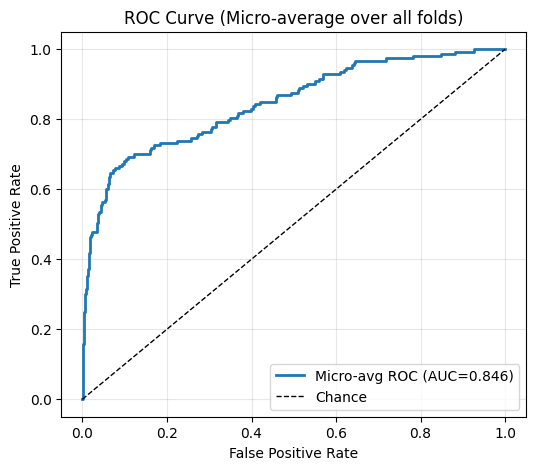

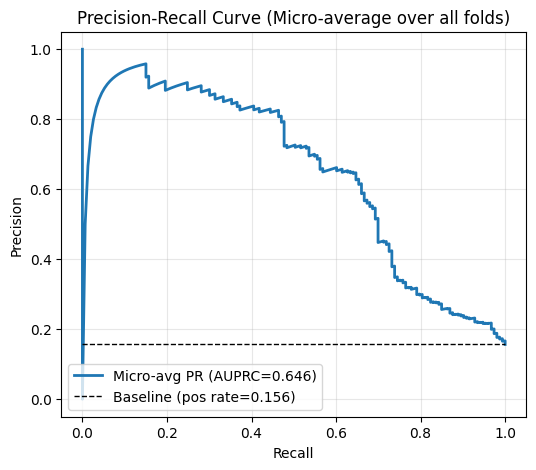

In [39]:
records = df_av['record'].astype(str).tolist()
labels  = df_av['label'].to_numpy().astype(int)

def compute_class_weight(y_train: np.ndarray) -> dict:
    s0 = (y_train == 0).sum(); s1 = (y_train == 1).sum()
    w0 = 2*s1/(s0 + s1) if (s0+s1)>0 else 1.0
    w1 = 2*s0/(s0 + s1) if (s0+s1)>0 else 1.0
    return {0: float(w0), 1: float(w1)}

def get_pair(idx_list: List[int]) -> Tuple[np.ndarray, np.ndarray]:
    S_list, g_list = [], []
    for i in idx_list:
        S, g = get_features(records[i])
        S_list.append(S); g_list.append(g)
    # هم‌طول کردن زمان برای batch
    t = min(m.shape[0] for m in S_list)
    S_list = [m[:t] for m in S_list]
    S_arr = np.stack(S_list, axis=0)  # [N, T, F]
    G_arr = np.stack(g_list, axis=0)  # [N, G]
    # الصاق ویژگی‌های بالینی (در صورت وجود)
    if clin_matrix.shape[1] > 0:
        G_arr = np.concatenate([G_arr, clin_matrix[idx_list]], axis=1)
    return S_arr, G_arr

n_splits  = 5
n_repeats = 3   # برای تست سریع؛ بعداً می‌تونی بزرگ‌ترش کنی (10–20)
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=SEED)



# ---- تنظیمات ساده برای عدم‌توازن و تقویت ----
POS_MULT   = 2      # چند برابر کردن کلاس مثبت (2 یعنی دو برابر)
JIT_PROB   = 0.30   # احتمال اِعمال نویز روی هر نمونه‌ی train
NOISE_STD  = 0.01   # شدت نویز گاوسی روی S (پس از اسکیل)
VAL_METRIC = 'val_auc'

fold_id = 0

all_aucs   = []    # اگر از قبل داری، نگهش دار
all_auprc  = []    # لیست AUPRC هر فولد
all_true   = []    # برچسب‌های همه‌ی فولدها برای micro-average
all_score  = []    # احتمال‌های خروجی همه‌ی فولدها برای micro-average


for train_idx, test_idx in rskf.split(np.zeros(len(labels)), labels):
    fold_id += 1
    print(f"\n=== Fold {fold_id}/{n_splits*n_repeats} ===")

    y_train_full, y_test = labels[train_idx], labels[test_idx]
    cw = compute_class_weight(y_train_full)
    print('Class weights:', cw)

    # ولیدیشن صریح داخل train
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    inner_train_idx, val_idx = next(sss.split(np.zeros(len(train_idx)), y_train_full))
    tr_ids = [train_idx[i] for i in inner_train_idx]
    va_ids = [train_idx[i] for i in val_idx]

    # ساخت X (سکانسی S) و G (برداری) برای هر بخش
    S_tr, G_tr = get_pair(tr_ids)
    S_va, G_va = get_pair(va_ids)
    S_te, G_te = get_pair(test_idx)
    y_tr = labels[tr_ids].astype(np.int32)
    y_va = labels[va_ids].astype(np.int32)

    # --------- استانداردسازی فقط با train فیت می‌شود ---------
    # سکانسی (بر حسب بُعد F)
    scaler_seq = StandardScaler()
    Ntr, T, F = S_tr.shape
    S_tr2 = S_tr.reshape(Ntr*T, F); scaler_seq.fit(S_tr2)
    S_tr = scaler_seq.transform(S_tr2).reshape(Ntr, T, F)

    Nva = S_va.shape[0]; S_va2 = S_va.reshape(Nva*T, F)
    S_va = scaler_seq.transform(S_va2).reshape(Nva, T, F)

    Nte = S_te.shape[0]; S_te2 = S_te.reshape(Nte*T, F)
    S_te = scaler_seq.transform(S_te2).reshape(Nte, T, F)

    # برداری (global + clinical)
    scaler_vec = StandardScaler()
    G_tr = scaler_vec.fit_transform(G_tr)
    G_va = scaler_vec.transform(G_va)
    G_te = scaler_vec.transform(G_te)

    # --------- Oversample ساده روی کلاس مثبت + نویز تقویتی روی S ---------
    S_up, G_up, y_up = S_tr, G_tr, y_tr
    pos_idx = np.where(y_tr == 1)[0]
    if len(pos_idx) and POS_MULT > 1:
        rep = np.random.choice(pos_idx, size=len(pos_idx) * (POS_MULT - 1), replace=True)
        S_up = np.concatenate([S_up, S_tr[rep]], axis=0)
        G_up = np.concatenate([G_up, G_tr[rep]], axis=0)
        y_up = np.concatenate([y_up, y_tr[rep]], axis=0)

    # نویز ملایم (jitter) فقط روی بخشی از train برای جلوگیری از overfit
    if JIT_PROB > 0:
        m = S_up.shape[0]
        mask = np.random.rand(m) < JIT_PROB
        if mask.any():
            S_up[mask] = S_up[mask] + np.random.normal(0.0, NOISE_STD, size=S_up[mask].shape)

    # نوع داده‌ها
    S_up = S_up.astype(np.float32); G_up = G_up.astype(np.float32); y_up = y_up.astype(np.float32)
    S_va = S_va.astype(np.float32);  G_va = G_va.astype(np.float32);  y_va = y_va.astype(np.float32)
    S_te = S_te.astype(np.float32);  G_te = G_te.astype(np.float32)

    # --------- مدل و آموزش ---------
    tf.keras.backend.clear_session()
    model = build_fusion_model(T, F, G_DIM, clin_matrix.shape[1], l2=2e-4, dropout=0.4)

    es    = callbacks.EarlyStopping(monitor=VAL_METRIC, patience=10, mode='max', restore_best_weights=True)
    rlrop = callbacks.ReduceLROnPlateau(monitor=VAL_METRIC, factor=0.5, patience=5, mode='max', verbose=1)

    # توجه: چون oversample انجام داده‌ایم، همچنان می‌توان class_weight را نگه داشت
    hist = model.fit(
        {'S': S_up, 'G': G_up}, y_up,
        validation_data=({'S': S_va, 'G': G_va}, y_va),
        epochs=60,
        batch_size=16,
        class_weight=cw,
        callbacks=[es, rlrop],
        verbose=0
    )

    # ارزیابی روی تست (کاملاً دیده‌نشده)
    
    proba = model.predict({'S': S_te, 'G': G_te}, verbose=0).ravel()
    # --- معیارهای هر فولد
    auprc = average_precision_score(y_test, proba)
    print(f"AUPRC={auprc:.4f}")
    all_auprc.append(auprc)

    # برای میکرو-اَوِرِیج نهایی (اتصال تمامی فولدها)
    all_true.append(y_test.astype(int))
    all_score.append(proba.astype(float))

    auc = roc_auc_score(labels[test_idx], proba)
    print('AUC:', round(auc, 4))
    all_aucs.append(auc)

    # پاکسازی حافظه
    del S_tr, S_va, S_te, G_tr, G_va, G_te, S_tr2, S_va2, S_te2, S_up, G_up, y_up
    gc.collect()




#print("\nSummary over folds:")
#print('Mean AUC:', float(np.mean(all_aucs)))
#print('Std  AUC:', float(np.std(all_aucs)))



# ---------- خلاصه‌ی کارایی روی فولدها ----------
mean_auc   = float(np.mean(all_aucs))
std_auc    = float(np.std(all_aucs))
mean_auprc = float(np.mean(all_auprc))
std_auprc  = float(np.std(all_auprc))

print("\nSummary over folds:")
print(f"Mean AUC   : {mean_auc:.6f}")
print(f"Std  AUC   : {std_auc:.6f}")
print(f"Mean AUPRC : {mean_auprc:.6f}")
print(f"Std  AUPRC : {std_auprc:.6f}")

# ---------- ROC & PR (micro-average) ----------
y_all = np.concatenate(all_true)
p_all = np.concatenate(all_score)

# ROC
fpr, tpr, _ = roc_curve(y_all, p_all)
# PR
prec, rec, _ = precision_recall_curve(y_all, p_all)
pos_rate = y_all.mean()  # خط مبنا برای PR

# نمودار ROC
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"Micro-avg ROC (AUC={roc_auc_score(y_all, p_all):.3f})")
plt.plot([0,1], [0,1], 'k--', lw=1, label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Micro-average over all folds)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
# plt.savefig("roc_micro.png", dpi=150, bbox_inches="tight")  # در صورت نیاز ذخیره کن
plt.show()

# نمودار Precision-Recall
plt.figure(figsize=(6,5))
plt.plot(rec, prec, lw=2, label=f"Micro-avg PR (AUPRC={average_precision_score(y_all, p_all):.3f})")
plt.hlines(pos_rate, 0, 1, colors='k', linestyles='--', lw=1, label=f"Baseline (pos rate={pos_rate:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Micro-average over all folds)")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
# plt.savefig("pr_micro.png", dpi=150, bbox_inches="tight")   # در صورت نیاز ذخیره کن
plt.show()

